In [ ]:
%matplotlib inline

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid")
PATH = Path('data')

from itertools import product

def date_breakdown(df,col):
    df[f'{col}_year']=df[col].dt.year
    df[f'{col}_month']=df[col].dt.month
    df[f'{col}_day']=df[col].dt.day
    df[f'{col}_dayofweek']=df[col].dt.dayofweek
    df[f'{col}_weekofyear'] = df[col].dt.weekofyear
    return df
def get_data():
    df= pd.read_csv(PATH/'employee_retention_data.csv',parse_dates=['join_date', 'quit_date'])
    for col in ['join_date','quit_date']:
        df = date_breakdown(df,col)
    df['quit'] = ~df.quit_date.isnull()
    df['employed_delta'] = (df.quit_date - df.join_date) / np.timedelta64(1, 'M')
    df.drop(df[df.seniority>=90].index,inplace=True)
    df = df.sort_values('join_date').reset_index(drop=True)
    return df
def get_headcount():
    df = get_data()
    
    dates=pd.date_range('2011-01-24','2015-12-23').values
    companies=sorted(df.company_id.unique())
    
    df_headcount=pd.DataFrame(list(product(*[dates,companies])),columns=['date','company_id'])
    df_headcount.date = pd.to_datetime(df_headcount.date)
    df_join=df.groupby(['join_date','company_id']).size().reset_index(name='join_count')
    df_quit = df.groupby(['quit_date','company_id']).size().reset_index(name='quit_count')
    df_headcount = df_headcount.merge(df_join,how='left',
                                      left_on=['date','company_id'],
                                      right_on=['join_date','company_id'])
    df_headcount = df_headcount.merge(df_quit,how='left',
                                      left_on=['date','company_id'],
                                      right_on=['quit_date','company_id'])
    df_headcount.drop(['join_date','quit_date'],axis=1,inplace=True)
    df_headcount.fillna(0,inplace=True)
    
    df_headcount['headcount'] = df_headcount.groupby('company_id').join_count.cumsum() \
                                    - df_headcount.groupby('company_id').quit_count.cumsum()
    for col in df_headcount.columns.values[-3:]:
        df_headcount[col] = df_headcount[col].astype(np.int32)
    df_headcount = date_breakdown(df_headcount,'date')
    return df_headcount

In [5]:
df = get_data()

In [7]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,join_date_year,join_date_month,join_date_day,join_date_dayofweek,join_date_weekofyear,quit_date_year,quit_date_month,quit_date_day,quit_date_dayofweek,quit_date_weekofyear,quit,employed_delta
0,679816.0,3,engineer,18,243000.0,2011-01-24,2015-08-07,2011,1,24,0,4,2015.0,8.0,7.0,4.0,32.0,True,54.407688
1,280323.0,1,data_science,1,74000.0,2011-01-24,2012-08-31,2011,1,24,0,4,2012.0,8.0,31.0,4.0,35.0,True,19.220107
2,554358.0,1,customer_service,8,67000.0,2011-01-24,2013-03-01,2011,1,24,0,4,2013.0,3.0,1.0,4.0,9.0,True,25.199696
3,527591.0,2,engineer,11,178000.0,2011-01-24,2011-12-16,2011,1,24,0,4,2011.0,12.0,16.0,4.0,50.0,True,10.710692
4,897062.0,3,engineer,17,240000.0,2011-01-24,2012-02-10,2011,1,24,0,4,2012.0,2.0,10.0,4.0,6.0,True,12.550566


# TODO: relabel independent variable: don't quit / quit after aprox 1 year / quit after approx 2 years (quit after > 2 years???)

# Train: 2011 and 2012, test on 2013

# Pick a simple random forest (few trees) and intepret some of them for some specific record (Jeremy)

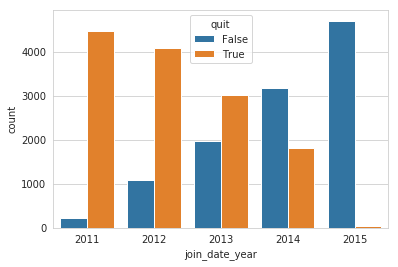

In [18]:
sns.countplot(x='join_date_year',data=df,hue='quit')

In [27]:
df[df.employed_delta>30].shape[0] / len(df)

0.09793522267206478

In [29]:
delta = df.loc[df.quit,'employed_delta']
delta[delta.between(15,18)].describe()


count    123.000000
mean      16.225772
std        1.045045
min       15.014682
25%       15.310376
50%       15.934619
75%       17.380234
max       17.971622
Name: employed_delta, dtype: float64

In [25]:
df[df.join_date_year>2013].quit.value_counts()

False    7913
True     1868
Name: quit, dtype: int64

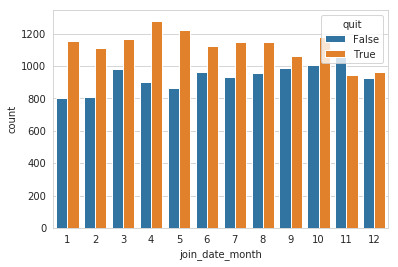

In [19]:
sns.countplot(x='join_date_month',data=df,hue='quit')

In [14]:
df.quit.value_counts(0)

True     13508
False    11192
Name: quit, dtype: int64

In [17]:
pd.to_datetime('2015-12-13') - pd.DateOffset(days=365 + 31)

Timestamp('2014-11-12 00:00:00')